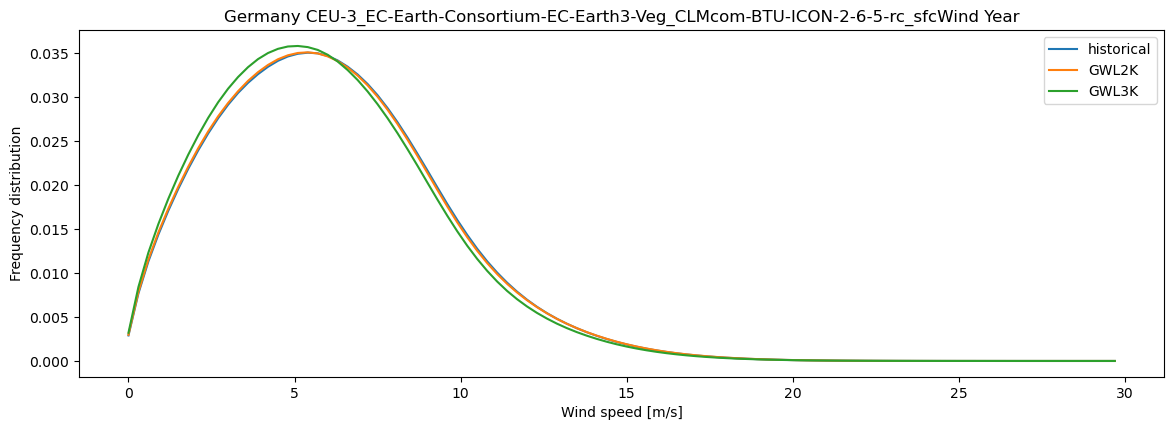

In [3]:
# sfcWind speed histogram
import json

import matplotlib.pyplot as plt
import numpy as np

region = "Germany"
with open(f"sfcWind/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_sfcWind"
    Hereon_data = wind_stats[dataset]
    edges = wind_stats["edges"]
    wind_hist = Hereon_data["historical"]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]

    season = "Year"
    max_count = max(
        wind_hist[season]["counts"]
        + wind_2K[season]["counts"]
        + wind_3K[season]["counts"]
    )
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(
            edges[:-1],
            np.array(data[season]["counts"]) / np.sum(data[season]["counts"]),
            label=labels[index],
        )
        # plt.stairs(data["counts"], edges,label=labels[index])
    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("Frequency distribution")
    plt.xlabel("Wind speed [m/s]")
    plt.legend()
    plt.savefig("Publikation/Wind_histogram.pdf", bbox_inches="tight", format="pdf", dpi=300)
    plt.show()

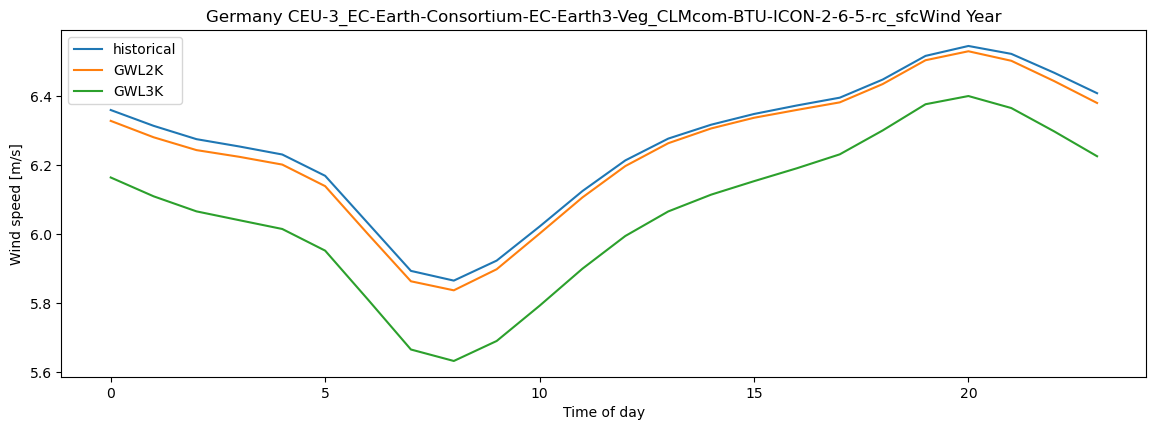

: 

In [ ]:
# Wind speed daily cycle
import json
import matplotlib.pyplot as plt

region = "Germany"
with open(f"sfcWind/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_sfcWind"
    Hereon_data = wind_stats[dataset]
    wind_hist = Hereon_data["historical"]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]
    season = "Year"
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(data[season]["diurnal_cycle"], label=labels[index])

    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("Wind speed [m/s]")
    plt.xlabel("Time of day")
    plt.legend()
    plt.savefig("Publikation/Wind_daily_cycle.pdf", bbox_inches="tight", format="pdf", dpi=300)

    plt.show()

In [4]:
import json
from collections import defaultdict


def latex_escape(s):
    return s.replace("_", "\\_")


# 1) Load data
with open("sfcWind/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

# 2) Flatten out (res, gcm, rcm, scenario, mean) — always use "Year"
season = "Year"
entries = []

for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        # grab mean for Year, skip if missing
        mean_val = stats.get(season, {}).get("mean")
        if mean_val is None:
            continue

        entries.append((res, gcm, rcm, scen, f"{mean_val:.2f}"))

# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val in entries:
    grouped[res][gcm][rcm].append((scen, val))

# 4) Build LaTeX
num_cols = 5  # total columns in the tabular environment

lines = [
    "\\begin{table}[htbp]",
    "\\centering",
    "\\resizebox{1.2\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|r}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Value \\\\",
    "\\midrule",
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(
        len(s_list) for rcm_dict in gcm_blocks.values() for s_list in rcm_dict.values()
    )
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\caption{Mean wind speed grouped by Resolution, GCM, RCM and Scenario}",
    "\\end{table}",
]

with open("Publikation/Wind_table.txt", "w") as file:
    for item in lines:
        file.write(item + "\n")


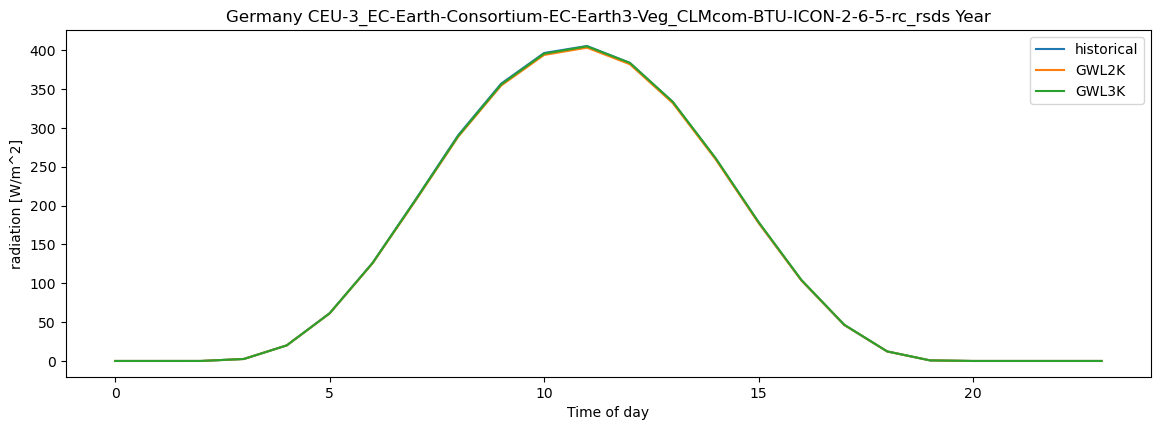

In [5]:
# PV daily cycle
import json
import matplotlib.pyplot as plt

region = "Germany"
with open(f"rsds/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_rsds"
    Hereon_data = wind_stats[dataset]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]
    season = "Year"
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    wind_hist = Hereon_data["historical"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(data[season]["diurnal_cycle"], label=labels[index])

    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("radiation [W/m^2]")
    plt.xlabel("Time of day")
    plt.legend()
    plt.savefig("Publikation/PV_daily_cycle.pdf", bbox_inches="tight", format="pdf", dpi=300)
    plt.show()

In [6]:
#PV Table
import json
from collections import defaultdict


def latex_escape(s):
    return s.replace("_", "\\_")


# 1) Load data
with open("rsds/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

# 2) Flatten out (res, gcm, rcm, scenario, mean) — always use "Year"
season = "Year"
entries = []

for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        # grab mean for Year, skip if missing
        mean_val = stats.get(season, {}).get("mean")
        if mean_val is None:
            continue

        entries.append((res, gcm, rcm, scen, f"{mean_val:.2f}"))


# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val in entries:
    grouped[res][gcm][rcm].append((scen, val))

# 4) Build LaTeX
num_cols = 5  # total columns in the tabular environment

lines = [
    "\\begin{table}[htbp]",
    "\\centering",
    "\\resizebox{1.2\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|r}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Value \\\\",
    "\\midrule",
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(
        len(s_list) for rcm_dict in gcm_blocks.values() for s_list in rcm_dict.values()
    )
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\caption{Mean rsds grouped by Resolution, GCM, RCM and Scenario}",
    "\\end{table}",
]

with open("Publikation/PV_table.txt", "w") as file:
    for item in lines:
        file.write(item + "\n")


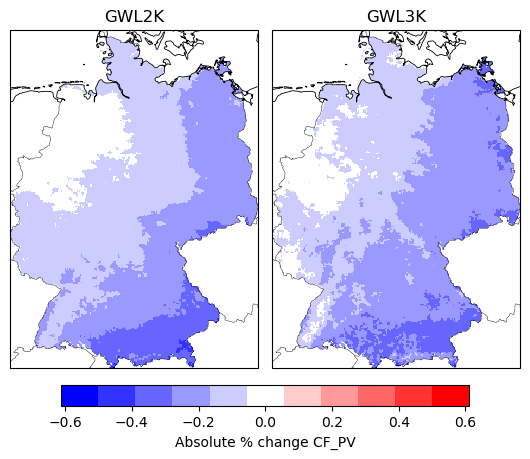

Mean value historical: 12.46%
Mean value GWL2K: 12.31%
Mean value GWL3K: 12.29%
Mean difference GWL2K: -0.15%
Mean difference GWL3K: -0.17%


In [7]:
# Changes to CF_PV
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(
    pole_longitude=198.0, pole_latitude=39.25
)  # Example values

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(14, 4.5),
    subplot_kw=dict(projection=rotated_pole),
    layout="compressed",
)


discrete_cmap = plt.get_cmap("bwr", 11)
discrete_cmap.set_bad(color=(0, 0, 0, 0))

with open("CF_PV/Germany.json", "r", encoding="utf-8") as file:
    file_locations = json.load(file)
    data_location = file_locations[
        "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_PV"
    ]
    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
    file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

    GWL2K = file_2["CF_PV"].values - file_1["CF_PV"].values
    GWL3K = file_3["CF_PV"].values - file_1["CF_PV"].values

    v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K)) * 100
    v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K)) * 100
    if abs(v_min) > abs(v_max):
        v_max = abs(v_min)
    else:
        v_min = -v_max

    files = [GWL2K, GWL3K]
    scenarios = ["GWL2K", "GWL3K"]

    for ax, file, scenario in zip(axes, files, scenarios):
        cf_flaute = file * 100
        lat = file_1["lat"].values
        lon = file_1["lon"].values

        cf_masked = np.squeeze(np.ma.masked_equal(cf_flaute, 0))

        pm = ax.pcolormesh(
            lon,
            lat,
            cf_masked,
            cmap=discrete_cmap,
            vmin=v_min,
            vmax=v_max,
            shading="auto",
            transform=ccrs.PlateCarree(),
        )  # Assuming lat/lon are in regular geographic coords

        ax.coastlines(linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.set_title(scenario, fontsize=12)

    cbar = fig.colorbar(
        pm,
        ax=axes.ravel().tolist(),
        orientation="horizontal",
        pad=0.05,
        shrink=0.8,
        label=f"Absolute % change CF_PV",
    )
    plt.savefig("Publikation/CF_PV_change_scenarios.pdf", bbox_inches="tight", format="pdf", dpi=300)
    plt.show()

    print(f"Mean value historical: {np.nanmean(file_1['CF_PV'].values)*100:.2f}%")
    print(f"Mean value GWL2K: {file_2['CF_PV'].mean().item()*100:.2f}%")
    print(f"Mean value GWL3K: {file_3['CF_PV'].mean().item()*100:.2f}%")
    print(f"Mean difference GWL2K: {np.nanmean(GWL2K)*100:.2f}%")
    print(f"Mean difference GWL3K: {np.nanmean(GWL3K)*100:.2f}%")

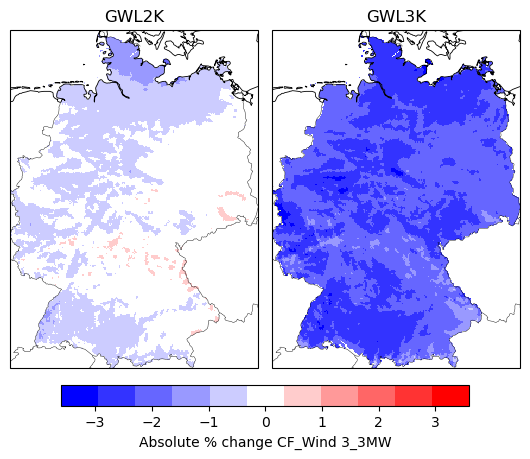

Mean value historical 3_3MW: 42.66%
Mean value GWL2K 3_3MW: 42.37%
Mean value GWL3K 3_3MW: 40.42%
Mean difference GWL2K 3_3MW: -0.29%
Mean difference GWL3K 3_3MW: -2.24%


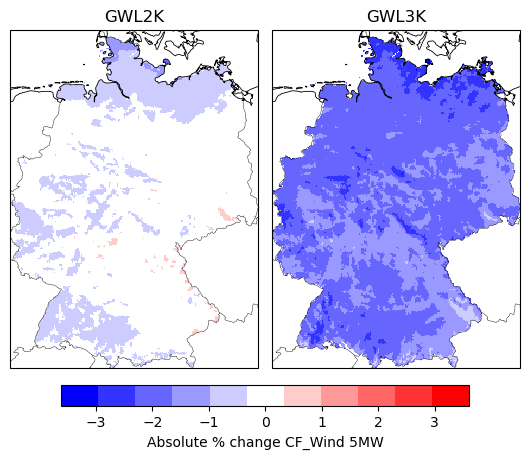

Mean value historical 5MW: 27.01%
Mean value GWL2K 5MW: 26.81%
Mean value GWL3K 5MW: 25.21%
Mean difference GWL2K 5MW: -0.20%
Mean difference GWL3K 5MW: -1.79%


In [8]:
# Changes to CF_Wind
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(
    pole_longitude=198.0, pole_latitude=39.25
)  # Example values


turbine_list = ["3_3MW", "5MW"]
for turbine in turbine_list:
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(14, 4.5),
        subplot_kw=dict(projection=rotated_pole),
        layout="compressed",
    )

    discrete_cmap = plt.get_cmap("bwr", 11)
    discrete_cmap.set_bad(color=(0, 0, 0, 0))
    with open("CF_Wind/Germany.json", "r", encoding="utf-8") as file:
        file_locations = json.load(file)
        data_location = file_locations[turbine][
            "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_Wind"
        ]
        file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
        file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
        file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

        GWL2K = file_2["CF_Wind"].values - file_1["CF_Wind"].values
        GWL3K = file_3["CF_Wind"].values - file_1["CF_Wind"].values

        v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K)) * 100
        v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K)) * 100
        if abs(v_min) > abs(v_max):
            v_max = abs(v_min)
        else:
            v_min = -v_max

        files = [GWL2K, GWL3K]
        scenarios = ["GWL2K", "GWL3K"]

        for ax, file, scenario in zip(axes, files, scenarios):
            cf_flaute = file * 100
            lat = file_1["lat"].values
            lon = file_1["lon"].values

            cf_masked = np.squeeze(np.ma.masked_equal(cf_flaute, 0))
            pm = ax.pcolormesh(
                lon,
                lat,
                cf_masked,
                cmap=discrete_cmap,
                vmin=v_min,
                vmax=v_max,
                shading="auto",
                transform=ccrs.PlateCarree(),
            )  # Assuming lat/lon are in regular geographic coords

            ax.coastlines(linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            ax.set_title(scenario, fontsize=12)

        cbar = fig.colorbar(
            pm,
            ax=axes.ravel().tolist(),
            orientation="horizontal",
            pad=0.05,
            shrink=0.8,
            label=f"Absolute % change CF_Wind {turbine}",
        )
        
        plt.savefig(f"Publikation/CF_Wind_changes_scenario_{turbine}.pdf", bbox_inches="tight", format="pdf", dpi=300)
        plt.show()

        print(
            f"Mean value historical {turbine}: {np.nanmean(file_1['CF_Wind'].values)*100:.2f}%"
        )
        print(f"Mean value GWL2K {turbine}: {file_2['CF_Wind'].mean().item()*100:.2f}%")
        print(f"Mean value GWL3K {turbine}: {file_3['CF_Wind'].mean().item()*100:.2f}%")
        print(f"Mean difference GWL2K {turbine}: {np.nanmean(GWL2K)*100:.2f}%")
        print(f"Mean difference GWL3K {turbine}: {np.nanmean(GWL3K)*100:.2f}%")

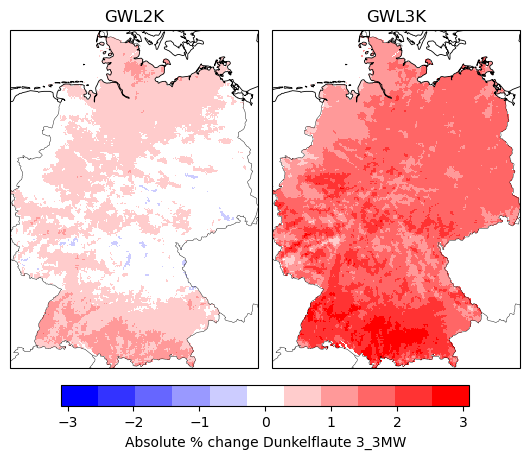

Mean value historical 3_3MW: 26.88%
Mean value GWL2K 3_3MW: 27.24%
Mean value GWL3K 3_3MW: 28.57%
Mean difference GWL2K 3_3MW: 0.36%
Mean difference GWL3K 3_3MW: 1.68%


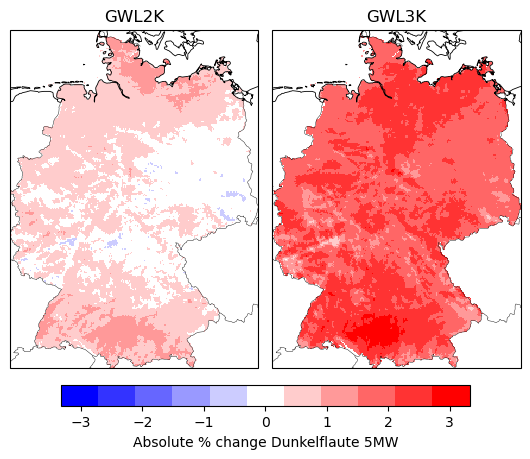

Mean value historical 5MW: 40.04%
Mean value GWL2K 5MW: 40.47%
Mean value GWL3K 5MW: 42.06%
Mean difference GWL2K 5MW: 0.43%
Mean difference GWL3K 5MW: 2.02%


In [9]:
# Changes to Dunkelflaute Germany (figure)
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(
    pole_longitude=198.0, pole_latitude=39.25
)  # Example values


turbine_list = ["3_3MW", "5MW"]
for turbine in turbine_list:
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(14, 4.5),
        subplot_kw=dict(projection=rotated_pole),
        layout="compressed",
    )

    discrete_cmap = plt.get_cmap("bwr", 11)
    discrete_cmap.set_bad(color=(0, 0, 0, 0))
    with open("Dunkelflaute/Germany.json", "r", encoding="utf-8") as file:
        file_locations = json.load(file)
        data_location = file_locations[turbine][
            "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_Dunkelflaute"
        ]
        file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
        file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
        file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

        GWL2K = file_2["Dunkelflaute"].values - file_1["Dunkelflaute"].values
        GWL3K = file_3["Dunkelflaute"].values - file_1["Dunkelflaute"].values

        v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K)) * 100
        v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K)) * 100
        if abs(v_min) > abs(v_max):
            v_max = abs(v_min)
        else:
            v_min = -v_max

        files = [GWL2K, GWL3K]
        scenarios = ["GWL2K", "GWL3K"]

        for ax, file, scenario in zip(axes, files, scenarios):
            cf_flaute = file * 100
            lat = file_1["lat"].values
            lon = file_1["lon"].values

            cf_masked = np.squeeze(np.ma.masked_equal(cf_flaute, 0))

            pm = ax.pcolormesh(
                lon,
                lat,
                cf_masked,
                cmap=discrete_cmap,
                vmin=v_min,
                vmax=v_max,
                shading="auto",
                transform=ccrs.PlateCarree(),
            )  # Assuming lat/lon are in regular geographic coords

            ax.coastlines(linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            ax.set_title(scenario, fontsize=12)

        cbar = fig.colorbar(
            pm,
            ax=axes.ravel().tolist(),
            orientation="horizontal",
            pad=0.05,
            shrink=0.8,
            label=f"Absolute % change Dunkelflaute {turbine}",
        )
        plt.savefig(f"Publikation/Dunkelflaute_change_scenarios_{turbine}.pdf", bbox_inches="tight", format="pdf", dpi=300)
        plt.show()

        print(
            f"Mean value historical {turbine}: {np.nanmean(file_1['Dunkelflaute'].values)*100:.2f}%"
        )
        print(f"Mean value GWL2K {turbine}: {file_2['Dunkelflaute'].mean().item()*100:.2f}%")
        print(f"Mean value GWL3K {turbine}: {file_3['Dunkelflaute'].mean().item()*100:.2f}%")
        print(f"Mean difference GWL2K {turbine}: {np.nanmean(GWL2K)*100:.2f}%")
        print(f"Mean difference GWL3K {turbine}: {np.nanmean(GWL3K)*100:.2f}%")

In [10]:
# Changes to Dunkelflaute Germany (RCM/GCM table)
import json
from collections import defaultdict
import xarray as xr
import numpy as np

def latex_escape(s):
    return s.replace("_", "\\_")


# 1) Load data
with open("Dunkelflaute/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

# 2) Flatten out (res, gcm, rcm, scenario, mean) — always use "Year"
season = "Year"
entries = []
wind_stats = wind_stats["3_3MW"]
for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        # grab mean for Year, skip if missing
        with xr.open_dataset(wind_stats[ds_name][scen][season]["fldmean"]) as df:
            mean_val = np.nanmean(df["Dunkelflaute"].values)
        if mean_val is None:
            continue

        entries.append((res, gcm, rcm, scen, f"{mean_val:.2f}"))

# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val in entries:
    grouped[res][gcm][rcm].append((scen, val))

# 4) Build LaTeX
num_cols = 5  # total columns in the tabular environment

lines = [
    "\\begin{table}[htbp]",
    "\\centering",
    "\\resizebox{1.2\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|r}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Value \\\\",
    "\\midrule",
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(
        len(s_list) for rcm_dict in gcm_blocks.values() for s_list in rcm_dict.values()
    )
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\caption{Mean wind speed grouped by Resolution, GCM, RCM and Scenario}",
    "\\end{table}",
]

with open("Publikation/Dunkelflaute_table.txt", "w") as file:
    for item in lines:
        file.write(item + "\n")

In [11]:
# Changes to Dunkelflaute Germany (regions)
import json
import xarray as xr
import numpy as np

regions = [
    "Duisburg",
    "Germany",
    "IAWAK-EE",
    "ISAP",
    "KARE",
    "KlimaKonform",
    "WAKOS",
]
output_filename="Publikation/Dunkelflaute_regional_table.txt"
with open(output_filename, "w", encoding="utf-8") as output_file:
    for region in regions:
        with open(f"Dunkelflaute/{region}.json", "r", encoding="utf-8") as file:
            file_locations = json.load(file)
            data_location = file_locations["3_3MW"][
                "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_Dunkelflaute"
            ]
            file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
            file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
            file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

            GWL2K = file_2["Dunkelflaute"].values - file_1["Dunkelflaute"].values
            GWL3K = file_3["Dunkelflaute"].values - file_1["Dunkelflaute"].values

            output_line = (
                f"{region}: {np.nanmean(file_1['Dunkelflaute'].values)*100:.2f}%, "
                f"{np.nanmean(GWL2K)*100:.2f}%, {np.nanmean(GWL3K)*100:.2f}%\n"
            )
            output_file.write(output_line)